<a href="https://colab.research.google.com/github/dinidini238-debug/tugas-face-recognition-ali-rayhaan/blob/main/face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ============================================================
# 1. MOUNT GOOGLE DRIVE
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

import cv2, os, base64
import numpy as np
from IPython.display import Javascript, display
from google.colab.output import eval_js
from IPython.display import Image

# Webcam function
def take_photo():
    js = Javascript('''
      async function takePhoto() {
        const div = document.createElement('div');
        document.body.appendChild(div);

        const video = document.createElement('video');
        video.style.width = '480px';
        div.appendChild(video);

        const stream = await navigator.mediaDevices.getUserMedia({video:true});
        video.srcObject = stream;
        await video.play();

        const btn = document.createElement('button');
        btn.textContent = "📸 Capture";
        div.appendChild(btn);

        await new Promise(resolve => btn.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);

        stream.getTracks()[0].stop();
        div.remove();
        return canvas.toDataURL("image/jpeg");
      }
    ''')
    display(js)
    data = eval_js("takePhoto()")
    img = base64.b64decode(data.split(',')[1])
    return img


# ============================================================
# 2. REGISTER WAJAH
# ============================================================
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

nama = input("Masukkan nama untuk registrasi: ").strip()
save_path = f"/content/drive/MyDrive/face_dataset/{nama}"
os.makedirs(save_path, exist_ok=True)

print(f"\n📸 Mulai mengambil 10 foto untuk: {nama}")

count = 1
while count <= 10:
    print(f"\nAmbil foto ke-{count}")
    img_bytes = take_photo()

    with open("temp.jpg", "wb") as f:
        f.write(img_bytes)

    img = cv2.imread("temp.jpg")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    if len(faces) == 0:
        print("❌ Tidak ada wajah, ulangi...")
        continue

    (x, y, w, h) = faces[0]
    face_crop = gray[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (200, 200))

    cv2.imwrite(f"{save_path}/{nama}_{count}.jpg", face_crop)
    print(f"✔ Foto {count} tersimpan")

    count += 1

print("\n🎉 Registrasi selesai!")
print("Dataset tersimpan di:", save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Masukkan nama untuk registrasi: ali

📸 Mulai mengambil 10 foto untuk: ali

Ambil foto ke-1


<IPython.core.display.Javascript object>

❌ Tidak ada wajah, ulangi...

Ambil foto ke-1


<IPython.core.display.Javascript object>

❌ Tidak ada wajah, ulangi...

Ambil foto ke-1


<IPython.core.display.Javascript object>

✔ Foto 1 tersimpan

Ambil foto ke-2


<IPython.core.display.Javascript object>

✔ Foto 2 tersimpan

Ambil foto ke-3


<IPython.core.display.Javascript object>

✔ Foto 3 tersimpan

Ambil foto ke-4


<IPython.core.display.Javascript object>

✔ Foto 4 tersimpan

Ambil foto ke-5


<IPython.core.display.Javascript object>

✔ Foto 5 tersimpan

Ambil foto ke-6


<IPython.core.display.Javascript object>

✔ Foto 6 tersimpan

Ambil foto ke-7


<IPython.core.display.Javascript object>

✔ Foto 7 tersimpan

Ambil foto ke-8


<IPython.core.display.Javascript object>

✔ Foto 8 tersimpan

Ambil foto ke-9


<IPython.core.display.Javascript object>

✔ Foto 9 tersimpan

Ambil foto ke-10


<IPython.core.display.Javascript object>

✔ Foto 10 tersimpan

🎉 Registrasi selesai!
Dataset tersimpan di: /content/drive/MyDrive/face_dataset/ali


In [3]:
# ============================================================
# Training LBPH Face Recognizer
# ============================================================
dataset_path = "/content/drive/MyDrive/face_dataset"
model_path = "/content/drive/MyDrive/face_model"
os.makedirs(model_path, exist_ok=True)

recognizer = cv2.face.LBPHFaceRecognizer_create()
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

faces = []
labels = []
label_map = {}  # nama → id
current_label = 0

print("🔄 Membaca folder dataset...")

for nama in os.listdir(dataset_path):
    person_folder = os.path.join(dataset_path, nama)
    if not os.path.isdir(person_folder):
        continue

    current_label += 1
    label_map[current_label] = nama

    for file in os.listdir(person_folder):
        if file.endswith(".jpg"):
            img = cv2.imread(os.path.join(person_folder, file), 0)
            faces.append(img)
            labels.append(current_label)

print("📚 Training model...")
recognizer.train(faces, np.array(labels))
recognizer.save(os.path.join(model_path, "face_model.xml"))

# simpan label map
import json
with open(os.path.join(model_path, "labels.json"), "w") as f:
    json.dump(label_map, f)

print("✔ Training selesai")
print("Model disimpan di:", model_path)

🔄 Membaca folder dataset...
📚 Training model...
✔ Training selesai
Model disimpan di: /content/drive/MyDrive/face_model


📸 Ambil foto untuk pengenalan...


<IPython.core.display.Javascript object>

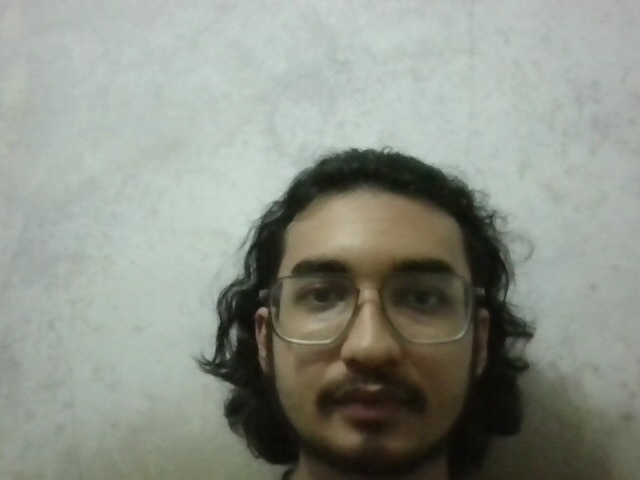


🔍 HASIL FACE RECOGNITION

🧑 Nama: ali
🎯 Confidence: 32.95180911965102
✔ Dikenali dengan baik



In [4]:
# ============================================================
# 3. Pengenalan wajah (Face Recognition)
# ============================================================
import json

recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.read("/content/drive/MyDrive/face_model/face_model.xml")

with open("/content/drive/MyDrive/face_model/labels.json", "r") as f:
    label_map = json.load(f)

print("📸 Ambil foto untuk pengenalan...")
img_bytes = take_photo()

with open("test.jpg", "wb") as f:
    f.write(img_bytes)

img = cv2.imread("test.jpg")
display(Image("test.jpg"))

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

print("\n🔍 HASIL FACE RECOGNITION\n")

if len(faces) == 0:
    print("❌ Tidak ada wajah ditemukan.")
else:
    for (x, y, w, h) in faces:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (200, 200))

        label, confidence = recognizer.predict(roi)
        nama = label_map.get(str(label), "Unknown")

        print(f"🧑 Nama: {nama}")
        print(f"🎯 Confidence: {confidence}")

        if confidence < 70:
            print("✔ Dikenali dengan baik\n")
        else:
            print("❌ Tidak cocok / wajah baru\n")